<a href="https://colab.research.google.com/github/dmejiaho/TAM-2025-2/blob/main/Tarea_5_Bayesiana__Regresion_sinc_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Diego Luis Salazar Perlaza

Daniel Mauricio Mejía Hoyos

Luis Fernando Castro Buchelly

Julian David Morales Pineda

Valeria García Rodas

In [65]:
!pip install optuna

##Librerias

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error


In [67]:

#función cálculo varianza del ruido a partir del snr dB
def var_snr(x,snrdB): #x vector de datos (señal), snrdB SNR en dB
    Px = np.mean(x**2)#estimador potencia media de la señal
    return Px/(10**(snrdB/10))

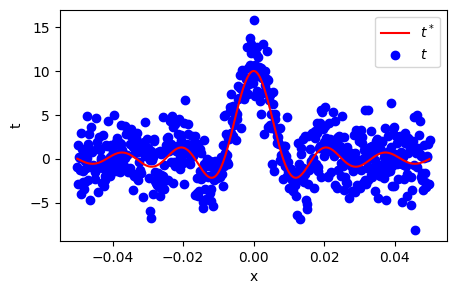

In [68]:
#datos simulados
Fo = 60 #frecuencia fundamental señal cos
A = 10 # amplitud de la señal
To = 1/Fo #periodo fundamental
Fs = 100*Fo #frecuencia muestreo según nyquist Fs >= 2 Fo
X = np.arange(-3*To,3*To,1/Fs) #vector de entrada en un periodo con pasos según período de muestreo

snrdB = 2 #ruido según SNR dB
#señal limpia - objetivo
argumento = 2*np.pi*Fo*X
# Manejo de la división por cero en el punto X=0
tt = np.zeros_like(argumento)
non_zero_indices = argumento != 0
tt[non_zero_indices] = A * np.sin(argumento[non_zero_indices]) / argumento[non_zero_indices]
#modelo con función sinoidal contaminada con ruido Gaussiano
t = (A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X)))/(2*np.pi*Fo*X)

potencia_ruido = var_snr(tt, snrdB)
ruido_gaussiano = np.sqrt(potencia_ruido) * np.random.randn(len(X))
t = tt + ruido_gaussiano

X = X.reshape(-1,1)#filas = realizaciones-muestras
t = t.reshape(-1,1)
tt = tt.reshape(-1,1)


plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()


In [69]:

# --- Split 70% train / 30% test ---
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, shuffle=True, random_state=42)


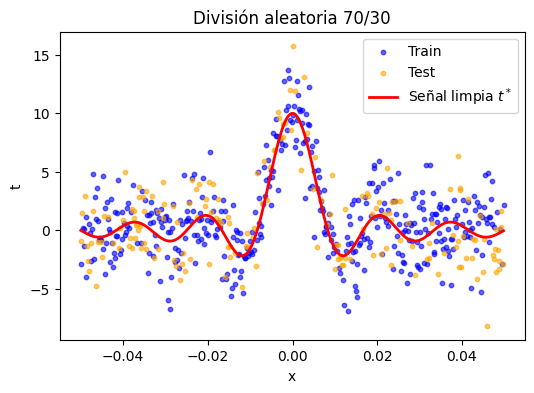

In [70]:
# --- Visualización ---
plt.figure(figsize=(6,4))
plt.scatter(X_train, t_train, c="blue", s=10, alpha=0.6, label="Train")
plt.scatter(X_test, t_test, c="orange", s=10, alpha=0.6, label="Test")
plt.plot(X, tt, 'r', linewidth=2, label="Señal limpia $t^*$")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.title("División aleatoria 70/30")
plt.show()


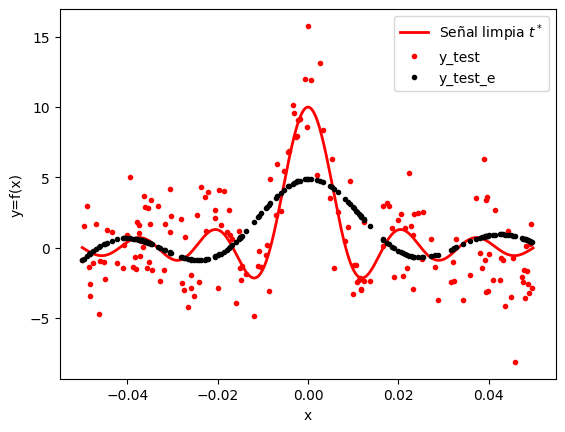

In [71]:

alpha = 0.11895494784850819
gamma = 982.0709485294749
reg = KernelRidge(kernel='rbf',gamma=gamma, alpha = alpha)
reg.fit(X_train,t_train) #ajustar solo sobre train
#prediccion
y_test_e = reg.predict(X_test)
y_train_e = reg.predict(X_train)
plt.plot(X, tt, 'r', linewidth=2, label="Señal limpia $t^*$")
plt.plot(X_test,t_test,'r.',label='y_test' )
plt.plot(X_test,y_test_e,'k.',label='y_test_e')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

##Bayesiana

In [72]:

Fo = 60 #frecuencia fundamental señal cos
A = 10 # amplitud de la señal
To = 1/Fo #periodo fundamental
Fs = 100*Fo #frecuencia muestreo según nyquist Fs >= 2 Fo
X = np.arange(-3*To,3*To,1/Fs) #vector de entrada en un periodo con pasos según período de muestreo

snrdB = 2 #ruido según SNR dB
#señal limpia - objetivo
argumento = 2*np.pi*Fo*X
# Manejo de la división por cero en el punto X=0
tt = np.zeros_like(argumento)
non_zero_indices = argumento != 0
tt[non_zero_indices] = A * np.sin(argumento[non_zero_indices]) / argumento[non_zero_indices]
#modelo con función sinoidal contaminada con ruido Gaussiano
t = (A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X)))/(2*np.pi*Fo*X)

# Assuming var_snr is defined in a previous cell or imported
# If not, you might need to copy the var_snr function definition as well.
# For now, assuming var_snr is available.
potencia_ruido = var_snr(tt, snrdB)
ruido_gaussiano = np.sqrt(potencia_ruido) * np.random.randn(len(X))
t = tt + ruido_gaussiano

X = X.reshape(-1,1)#filas = realizaciones-muestras
t = t.reshape(-1,1)
tt = tt.reshape(-1,1)


# Perform train-test split on the regenerated data
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, shuffle=True, random_state=42)


steps=[('reg', KernelRidge(kernel = 'rbf'))]
parameters = {'reg__alpha' : [0,1e-3,1e-2,0.1,1,10,100,1000],
              'reg__gamma': [1e-4,1e-3,1e-2,0.1,1,10,100,1000],
              }

pipeline = Pipeline(steps = steps)

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4,cv=10,
                           scoring='neg_mean_absolute_error',verbose=10,refit=True)

# Reshape t_train to a 1D array
t_train_reshaped = t_train.ravel()

grid_search.fit(X_train, t_train_reshaped)
#mejor modelo entrenado
best_model = grid_search.best_estimator_

print("\nMejores parámetros:\n")
print(grid_search.best_params_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits

Mejores parámetros:

{'reg__alpha': 0.001, 'reg__gamma': 1000}


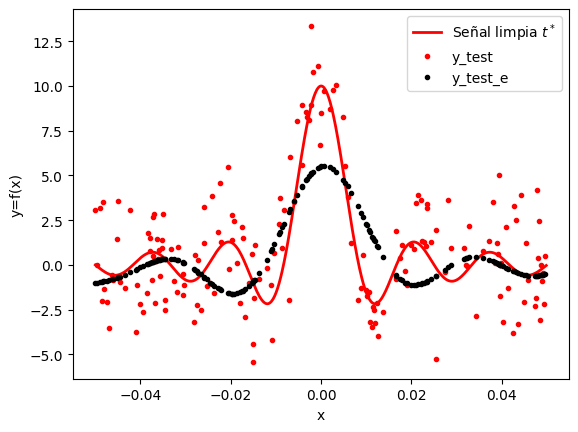

In [73]:

alpha = 0.001
gamma = 1000
reg = KernelRidge(kernel='rbf',gamma=gamma, alpha = alpha)
reg.fit(X_train,t_train) #ajustar solo sobre train
#prediccion
y_test_e = reg.predict(X_test)
y_train_e = reg.predict(X_train)
plt.plot(X, tt, 'r', linewidth=2, label="Señal limpia $t^*$")
plt.plot(X_test,t_test,'r.',label='y_test' )
plt.plot(X_test,y_test_e,'k.',label='y_test_e')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

In [74]:

# Se define la "función objetivo" que Optuna intentará minimizar.
# Esta función encapsula todo el proceso: crear modelo, entrenarlo y evaluarlo.
def objective(trial):
    # 1. Sugerir hiperparámetros para este "trial" (intento)
    # Optuna elegirá valores de forma inteligente dentro de estos rangos.
    alpha = trial.suggest_float('alpha', 1e-3, 1e3, log=True)
    gamma = trial.suggest_float('gamma', 1e-3, 1e3, log=True)

    # 2. Crear el modelo con los hiperparámetros sugeridos
    model = KernelRidge(kernel='rbf', alpha=alpha, gamma=gamma)

    # 3. Evaluar el modelo usando Validación Cruzada (¡la forma correcta!)
    # Esto evita usar el conjunto de test para la optimización.
    # Usamos el error cuadrático medio negativo porque Optuna minimiza por defecto.
    score = cross_val_score(model, X_train, t_train_reshaped, cv=10, scoring='neg_mean_squared_error')

    # 4. Devolver el promedio del error de la validación cruzada
    # Como el score es negativo, devolvemos su promedio.
    return np.mean(score)

# 1. Crear un "estudio" de Optuna. La meta es maximizar el score (que es negativo).
# Por lo tanto, usamos direction='maximize'.
study = optuna.create_study(direction='maximize')

# 2. Iniciar la optimización. Optuna llamará a la función 'objective' 40 veces.
study.optimize(objective, n_trials=40)


# --------------------------------------------------------------------------
# 4. OBTENCIÓN DE RESULTADOS
# --------------------------------------------------------------------------
print("Optimización con Optuna finalizada.")
print(f"Número de trials finalizados: {len(study.trials)}")

print("\nMejor trial:")
best_trial = study.best_trial
# El valor del score es negativo, lo multiplicamos por -1 para ver el MSE real
print(f"  Valor (MSE): {-best_trial.value:.6f}")
print("  Mejores Parámetros: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Entrenar el modelo final con los mejores parámetros encontrados en TODO el set de entrenamiento
best_params = study.best_params
final_model = KernelRidge(kernel='rbf', **best_params)
final_model.fit(X_train, t_train_reshaped)

# Evaluar el modelo final en el conjunto de test (que nunca fue usado en la optimización)
final_score = final_model.score(X_test, t_test)
print(f"\nR^2 score del modelo final en el conjunto de test: {final_score:.4f}")

Optimización con Optuna finalizada.
Número de trials finalizados: 40

Mejor trial:
  Valor (MSE): 10.812819
  Mejores Parámetros: 
    alpha: 9.56219030769483
    gamma: 967.5766702364231

R^2 score del modelo final en el conjunto de test: 0.1441


##Librerias Housing

In [75]:
from sklearn.datasets import fetch_california_housing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge

In [76]:
N = 1000 # # samples
P = 20 # # features
X, y = fetch_california_housing(return_X_y=True)
print(X.shape,y.shape)

(20640, 8) (20640,)


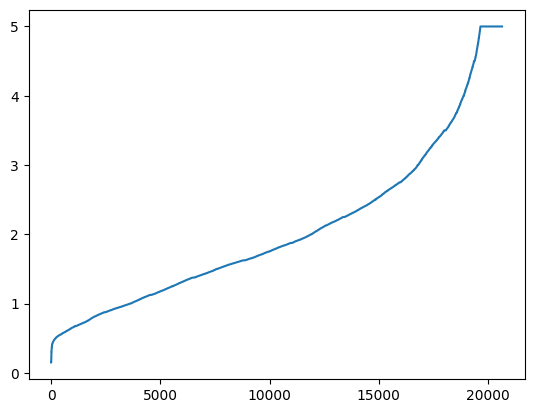

In [77]:
plt.plot(np.sort(y))
plt.show()

In [78]:

br = BayesianRidge(compute_score=True)  # ajusta lambdas automáticamente
br.fit(X_train, t_train.ravel())
y_pred = br.predict(X_test)
# obtener incertidumbre aproximada (std) no directamente en sklearn; para eso usar PyMC o GPR


Dimensiones de X (Ingreso Medio) California Housing: (20640, 1)
Dimensiones de y (Valor de la Vivienda) California Housing: (20640,)


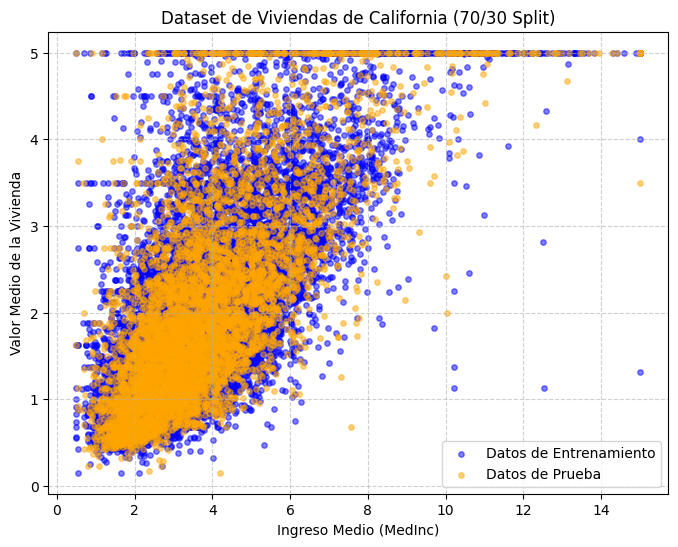

In [79]:


# --- 1. Cargar y preparar el dataset ---
# Cargamos el dataset de California Housing
X_full_cal, y_cal = fetch_california_housing(return_X_y=True)

# Para poder visualizar en 2D, seleccionamos solo una característica: el Ingreso Medio (MedInc).
# Esta es la primera columna (índice 0).
X_cal = X_full_cal[:, 0].reshape(-1, 1)

print(f"Dimensiones de X (Ingreso Medio) California Housing: {X_cal.shape}")
print(f"Dimensiones de y (Valor de la Vivienda) California Housing: {y_cal.shape}")

# --- 2. División 70% entrenamiento / 30% prueba ---
# Use different variable names to avoid conflict with simulated data split
X_train_cal, X_test_cal, y_train_cal, y_test_cal = train_test_split(X_cal, y_cal, test_size=0.3, random_state=42)

# --- Visualización inicial de los datos ---
plt.figure(figsize=(8, 6))
plt.scatter(X_train_cal, y_train_cal, c="blue", s=15, alpha=0.5, label="Datos de Entrenamiento")
plt.scatter(X_test_cal, y_test_cal, c="orange", s=15, alpha=0.5, label="Datos de Prueba")
plt.xlabel("Ingreso Medio (MedInc)")
plt.ylabel("Valor Medio de la Vivienda")
plt.title("Dataset de Viviendas de California (70/30 Split)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Iniciando la búsqueda de los mejores hiperparámetros...
Fitting 4 folds for each of 72 candidates, totalling 288 fits


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.56481e-21): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



¡Búsqueda completada!
Mejor grado de polinomio encontrado: 8
Mejor alpha para Ridge encontrado: 0.0052


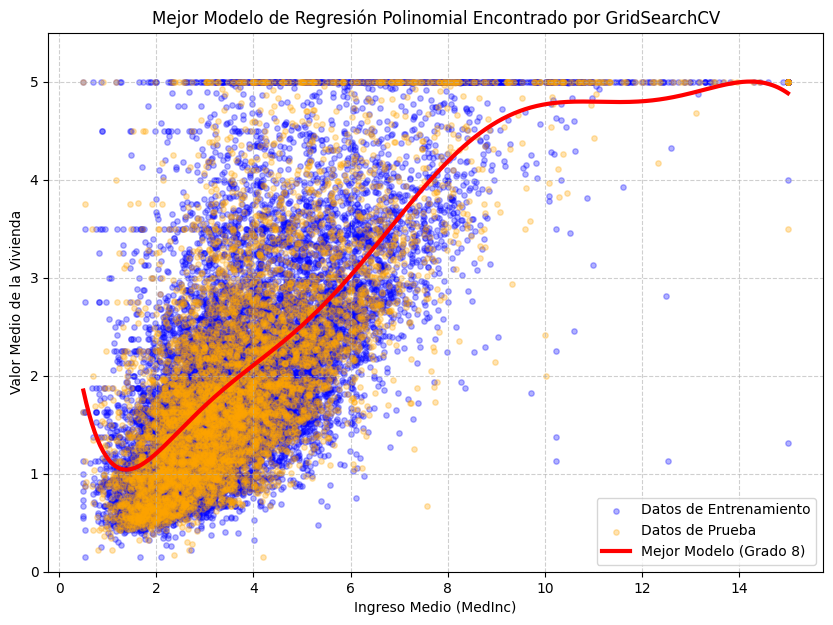


Generando gráficos comparativos para grados específicos...


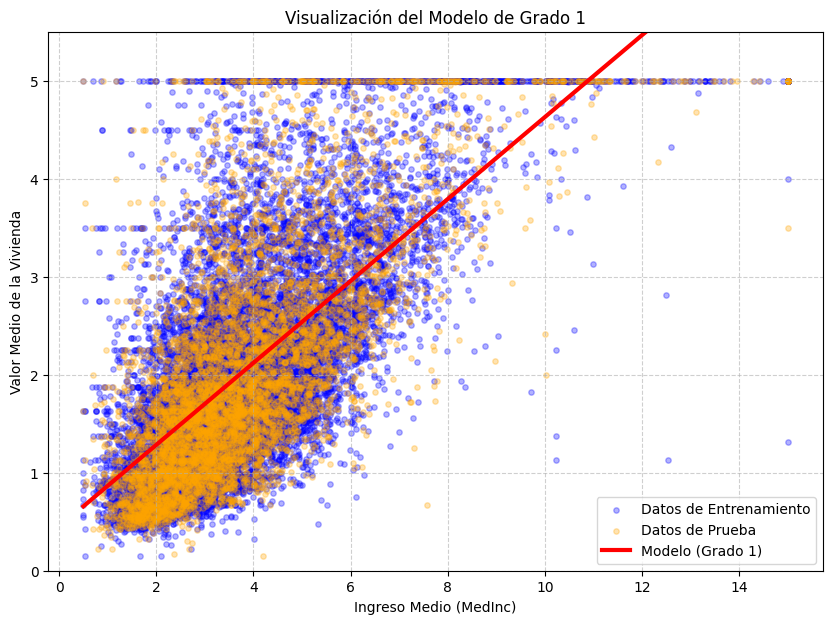

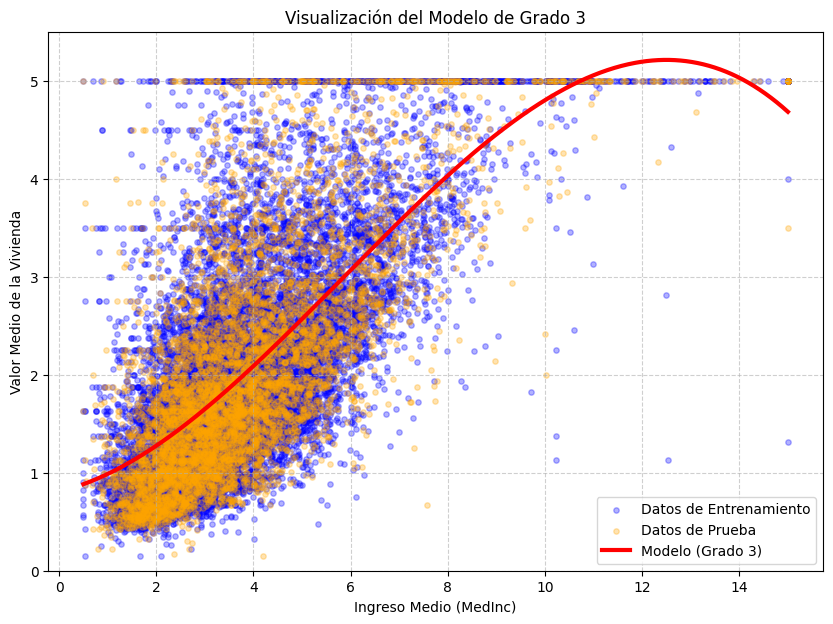

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.56481e-21): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


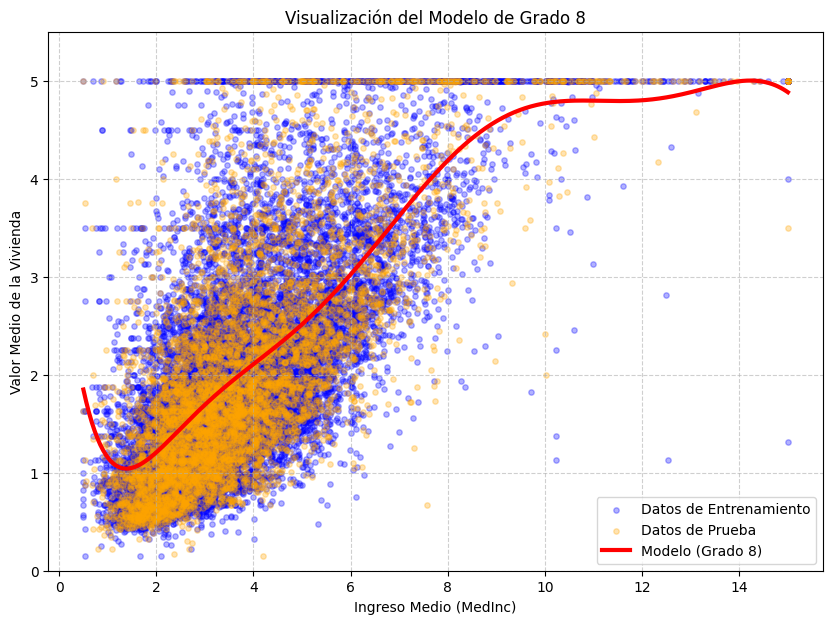

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.35101e-40): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


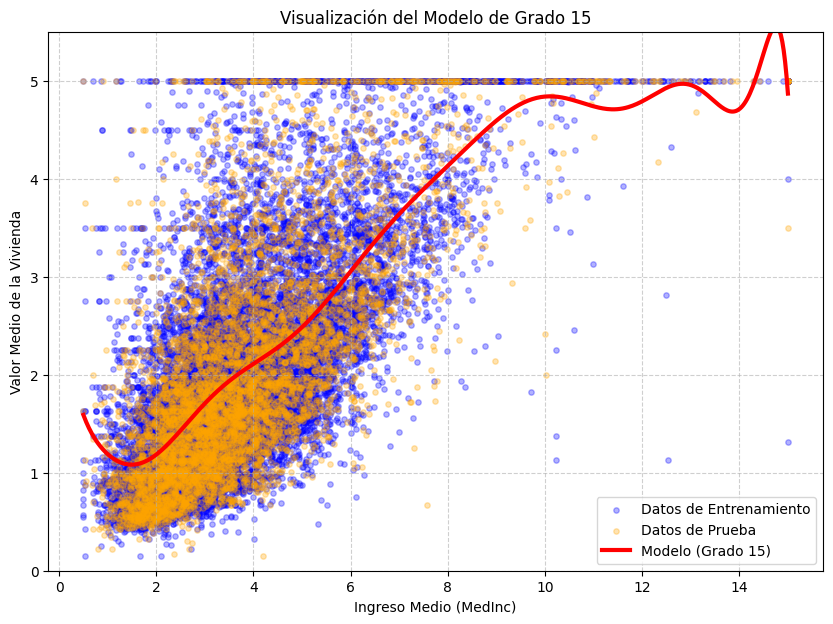

In [80]:
X_full, y = fetch_california_housing(return_X_y=True)
X = X_full[:, 0].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# (Opcional) Visualización inicial de los datos
# plt.figure(figsize=(8, 6))
# plt.scatter(X_train, y_train, c="blue", s=15, alpha=0.5, label="Datos de Entrenamiento")
# plt.scatter(X_test, y_test, c="orange", s=15, alpha=0.5, label="Datos de Prueba")
# plt.show()

# ---------------------------------------------------------------------------
# 2. DEFINIR EL PIPELINE Y LA PARRILLA DE PARÁMETROS
# ---------------------------------------------------------------------------
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ridge', Ridge())
])
param_grid = {
    'poly__degree': np.arange(1, 10),
    'ridge__alpha': np.logspace(-3, 2, 8)
}

# ---------------------------------------------------------------------------
# 3. EJECUTAR GRIDSEARCHCV CON 4 FOLDS
# ---------------------------------------------------------------------------
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=4,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
print("Iniciando la búsqueda de los mejores hiperparámetros...")
grid_search.fit(X_train, y_train)

# ---------------------------------------------------------------------------
# 4. MOSTRAR LOS MEJORES RESULTADOS
# ---------------------------------------------------------------------------
print("\n¡Búsqueda completada!")
best_degree = grid_search.best_params_['poly__degree']
best_alpha = grid_search.best_params_['ridge__alpha']
print(f"Mejor grado de polinomio encontrado: {best_degree}")
print(f"Mejor alpha para Ridge encontrado: {best_alpha:.4f}")

best_model = grid_search.best_estimator_

# ---------------------------------------------------------------------------
# 5. VISUALIZAR EL MEJOR MODELO ENCONTRADO
# ---------------------------------------------------------------------------
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, c="blue", s=15, alpha=0.3, label="Datos de Entrenamiento")
plt.scatter(X_test, y_test, c="orange", s=15, alpha=0.3, label="Datos de Prueba")
X_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_range_pred = best_model.predict(X_range)
plt.plot(X_range, y_range_pred, color='red', linewidth=3, label=f'Mejor Modelo (Grado {best_degree})')
plt.title('Mejor Modelo de Regresión Polinomial Encontrado por GridSearchCV')
plt.xlabel('Ingreso Medio (MedInc)')
plt.ylabel('Valor Medio de la Vivienda')
plt.legend()
plt.ylim(0, 5.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# ##############################################################################
# # 6. EXTRA: VISUALIZACIÓN COMPARATIVA DE DIFERENTES GRADOS (NUEVO CÓDIGO)
# ##############################################################################

print("\nGenerando gráficos comparativos para grados específicos...")
# Lista de los grados que quieres visualizar para comparar
grados_a_comparar = [1, 3, best_degree, 15]

for grado in grados_a_comparar:
    # Creamos un modelo específico para este grado
    # Usamos el MEJOR alpha que encontró GridSearchCV para una comparación justa
    modelo_especifico = Pipeline([
        ('poly', PolynomialFeatures(degree=grado, include_bias=False)),
        ('ridge', Ridge(alpha=best_alpha))
    ])

    # Entrenamos este modelo específico
    modelo_especifico.fit(X_train, y_train)

    # Generamos el gráfico
    plt.figure(figsize=(10, 7))
    plt.scatter(X_train, y_train, c="blue", s=15, alpha=0.3, label="Datos de Entrenamiento")
    plt.scatter(X_test, y_test, c="orange", s=15, alpha=0.3, label="Datos de Prueba")

    y_range_pred = modelo_especifico.predict(X_range)

    plt.plot(X_range, y_range_pred, color='red', linewidth=3, label=f'Modelo (Grado {grado})')
    plt.title(f'Visualización del Modelo de Grado {grado}')
    plt.xlabel('Ingreso Medio (MedInc)')
    plt.ylabel('Valor Medio de la Vivienda')
    plt.legend()
    plt.ylim(0, 5.5)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

##Bayesiana

Iniciando la búsqueda de hiperparámetros con Optuna...

 ¡Búsqueda completada!
Mejor grado de polinomio encontrado: 12
Mejor alpha para Ridge encontrado: 0.1339
Mejor valor de la función objetivo (neg_mean_squared_error): -0.6819


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.50102e-31): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


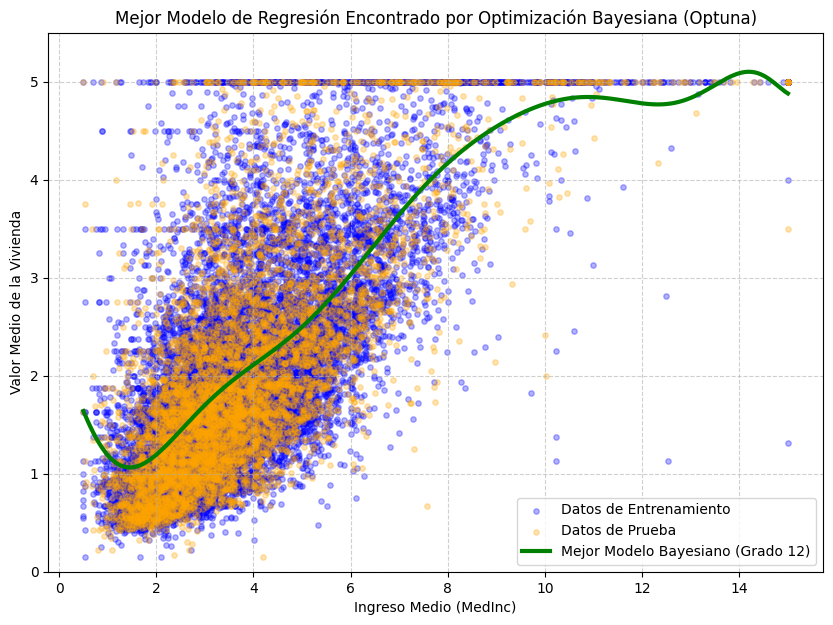


Generando gráficos comparativos para grados específicos...


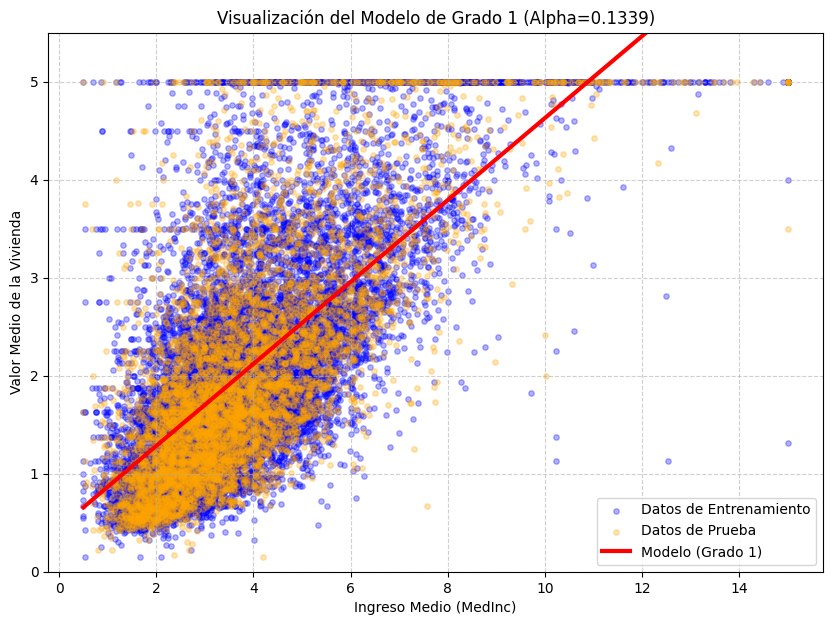

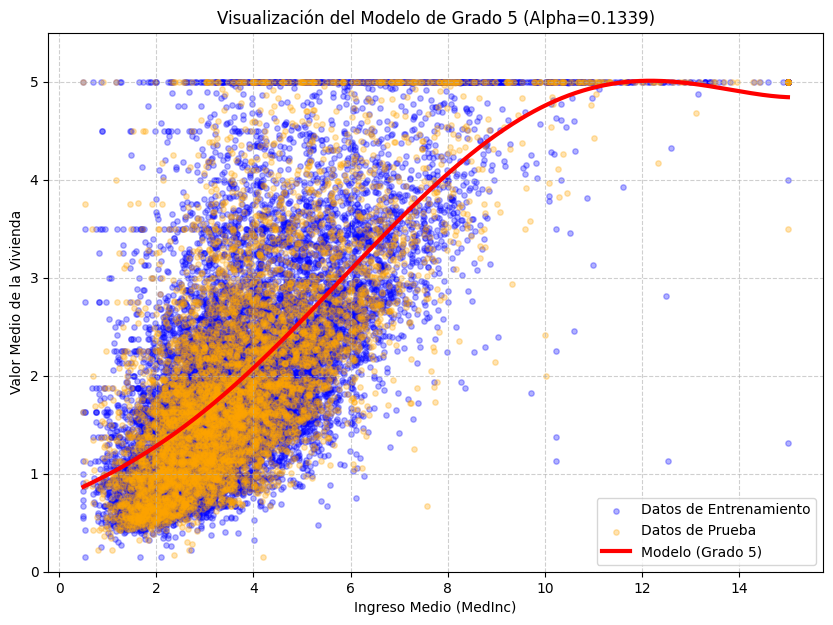

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.50102e-31): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


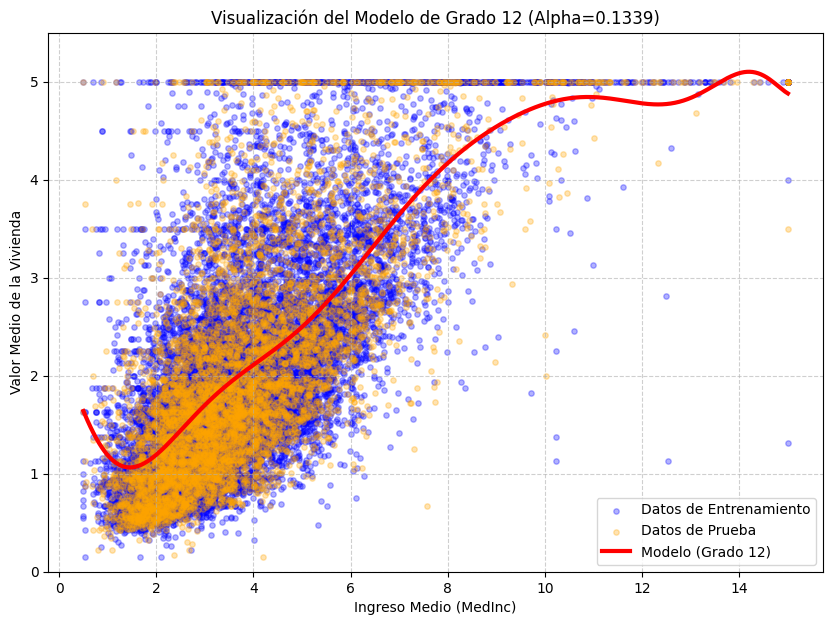

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.25821e-38): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


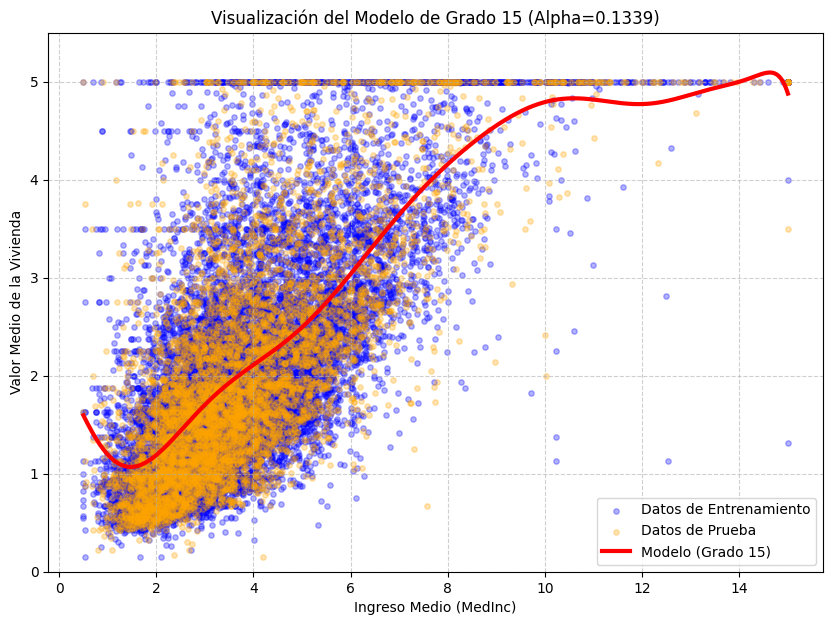

In [81]:

# ---------------------------------------------------------------------------
# 1. CARGAR Y PREPARAR LOS DATOS
# ---------------------------------------------------------------------------
# Esta parte se mantiene idéntica.
X_full, y = fetch_california_housing(return_X_y=True)
X = X_full[:, 0].reshape(-1, 1) # Usamos solo una característica para visualizar en 2D
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ---------------------------------------------------------------------------
# 2. DEFINIR LA FUNCIÓN OBJETIVO PARA OPTUNA
# ---------------------------------------------------------------------------
# Este es el núcleo de la optimización. Optuna llamará a esta función en
# cada intento ("trial") para evaluar un conjunto de hiperparámetros.
def objective(trial):
    """
    Define el espacio de búsqueda y el modelo a optimizar.
    `trial` es un objeto que sugiere los hiperparámetros en cada iteración.
    """
    # 2.1. Sugerir los hiperparámetros a probar en este "trial"
    # Para el grado del polinomio, sugerimos un entero entre 1 y 15.
    degree = trial.suggest_int('poly__degree', 1, 15)

    # Para alpha, sugerimos un flotante en escala logarítmica (ideal para regularización).
    alpha = trial.suggest_float('ridge__alpha', 1e-3, 1e2, log=True)

    # 2.2. Crear el pipeline con los hiperparámetros sugeridos
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('ridge', Ridge(alpha=alpha))
    ])

    # 2.3. Evaluar el modelo usando validación cruzada (4 folds como en tu código)
    # Usamos 'neg_mean_squared_error'. Optuna buscará maximizar este valor,
    # lo que equivale a minimizar el error cuadrático medio (MSE).
    score = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=4,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # 2.4. Devolver la métrica promedio de la validación cruzada.
    # Este es el valor que Optuna intentará maximizar.
    return score.mean()

# ---------------------------------------------------------------------------
# 3. EJECUTAR LA OPTIMIZACIÓN BAYESIANA CON OPTUNA
# ---------------------------------------------------------------------------
print("Iniciando la búsqueda de hiperparámetros con Optuna...")

# Creamos un "estudio". La `direction`='maximize' le indica a Optuna que
# debe maximizar el resultado de la función `objective`.
study = optuna.create_study(direction='maximize')

# Ejecutamos la optimización. Se realizarán 50 pruebas.
# Optuna usa los resultados de las pruebas anteriores para decidir qué probar después.
study.optimize(objective, n_trials=50)

# ---------------------------------------------------------------------------
# 4. MOSTRAR LOS MEJORES RESULTADOS
# ---------------------------------------------------------------------------
print("\n ¡Búsqueda completada!")
best_params = study.best_params
best_degree = best_params['poly__degree']
best_alpha = best_params['ridge__alpha']

print(f"Mejor grado de polinomio encontrado: {best_degree}")
print(f"Mejor alpha para Ridge encontrado: {best_alpha:.4f}")
print(f"Mejor valor de la función objetivo (neg_mean_squared_error): {study.best_value:.4f}")

# Entrenamos el mejor modelo con los hiperparámetros óptimos en todo el set de entrenamiento
best_model = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('ridge', Ridge(alpha=best_alpha))
])
best_model.fit(X_train, y_train)

# ---------------------------------------------------------------------------
# 5. VISUALIZAR EL MEJOR MODELO ENCONTRADO
# ---------------------------------------------------------------------------
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, c="blue", s=15, alpha=0.3, label="Datos de Entrenamiento")
plt.scatter(X_test, y_test, c="orange", s=15, alpha=0.3, label="Datos de Prueba")

X_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_range_pred = best_model.predict(X_range)

plt.plot(X_range, y_range_pred, color='green', linewidth=3, label=f'Mejor Modelo Bayesiano (Grado {best_degree})')
plt.title('Mejor Modelo de Regresión Encontrado por Optimización Bayesiana (Optuna)')
plt.xlabel('Ingreso Medio (MedInc)')
plt.ylabel('Valor Medio de la Vivienda')
plt.legend()
plt.ylim(0, 5.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


print("\nGenerando gráficos comparativos para grados específicos...")
# Puedes cambiar esta lista para explorar otros grados
grados_a_comparar = [1, 5, best_degree, 15]

# Usamos set para evitar duplicados si best_degree es uno de los valores de la lista
for grado in sorted(list(set(grados_a_comparar))):
    modelo_especifico = Pipeline([
        ('poly', PolynomialFeatures(degree=grado, include_bias=False)),
        # Usamos el MEJOR alpha encontrado para una comparación más justa
        ('ridge', Ridge(alpha=best_alpha))
    ])
    modelo_especifico.fit(X_train, y_train)
    y_range_pred = modelo_especifico.predict(X_range)

    plt.figure(figsize=(10, 7))
    plt.scatter(X_train, y_train, c="blue", s=15, alpha=0.3, label="Datos de Entrenamiento")
    plt.scatter(X_test, y_test, c="orange", s=15, alpha=0.3, label="Datos de Prueba")
    plt.plot(X_range, y_range_pred, color='red', linewidth=3, label=f'Modelo (Grado {grado})')
    plt.title(f'Visualización del Modelo de Grado {grado} (Alpha={best_alpha:.4f})')
    plt.xlabel('Ingreso Medio (MedInc)')
    plt.ylabel('Valor Medio de la Vivienda')
    plt.legend()
    plt.ylim(0, 5.5)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()